In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

In [ ]:
from n_framework import*
from activations_module import *

In [ ]:
# Image URLs for demos. Change as desired.
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"
     

In [ ]:
def download_image(url):
    imgb = fc.urlread(url, decode=False)
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255

content_imgae_shape: torch.Size([3, 256, 256])


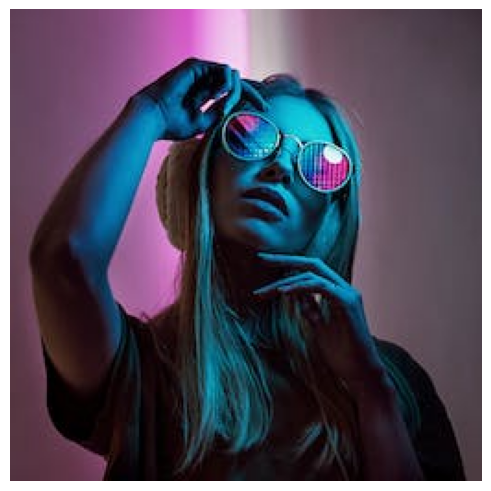

In [ ]:
content_img = download_image(face_url).to(def_device)
print('content_imgae_shape:',content_img.shape)
show_image(content_img);

In [ ]:
content_img.min(), content_img.max()

(tensor(0., device='mps:0'), tensor(1., device='mps:0'))

## optimizing an Image

In [ ]:
class LenghtDataset():
    def __init__(self, length=1): self.length = length
    def __len__(self): return self.length
    def __getitem__(self,idx): return 0,0
    
def getDummy_dls(length=100):
    return DataLoaders(DataLoader(LenghtDataset(length), batch_size=1), # train
                      DataLoader(LenghtDataset(1), batch_size=1)) # val,length=1

In [ ]:
# for batch in getDummy_dls(10).train:
#     print(batch)

In [ ]:
class TensorModel(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())
    def forward(self, x=0): return self.t

### Note:
    - when generating random like image with torch.rand_like(content_img) it weirdly outputs images like content_iimg but split in 9 frames in gray scale, and in 9**2 (81) frames if excuted again. `this feature is reserved to mps` macbook m1 results, becuase it works as inteded random noise in other cuda gpu. Solution-> use torch.rand(*content_img.shape) to solve this bug.
    - torch.rand_like(x) vs torch.rand(*x.shape) outputs totally different outcomes in `mps` GPU

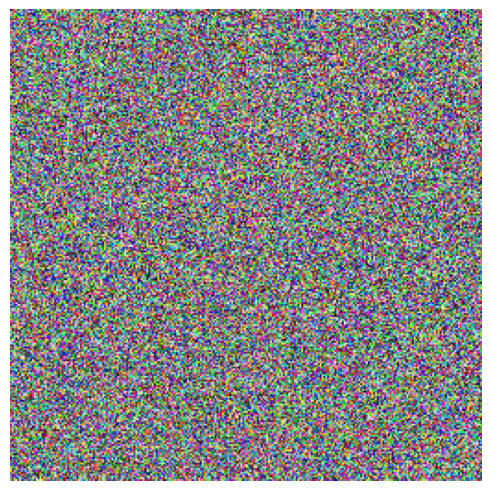

In [ ]:
model = TensorModel(torch.rand(*content_img.shape))
show_image(model());

In [ ]:
[p.shape for p in model.parameters()]

[torch.Size([3, 256, 256])]

In [ ]:
class ImageOptCB(TrainCB):
    def predict(self,learn): learn.preds = learn.model()
    def get_loss(self,learn): learn.loss = learn.loss_func(learn.preds)

In [ ]:
def loss_fn_mse(im):
    return F.mse_loss(im, content_img)

model = TensorModel(torch.rand(*content_img.shape))
cbs = [ImageOptCB(), ProgressCB(), MetricsCB(),DeviceCB()]
learn = Learner(model, getDummy_dls(100), loss_fn_mse,
                lr= 1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1)

loss,epoch,train
0.041,0,train
0.001,0,eval


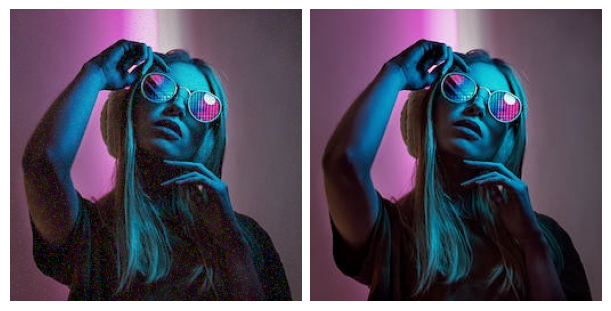

In [ ]:
show_images([learn.model().clip(0,1), content_img]);

###### lets view the progress

In [ ]:
class ImageLogCB(callback):
    order = ProgressCB.order + 1
    def __init__(self, log_every=10): store_attr();self.images=[]; self.i =0
    def after_batch(self, learn):
        if self.i%self.log_every ==0: self.images.append(to_cpu(learn.preds.clip(0,1)))
        self.i += 1
    def after_fit(self, learn): show_images(self.images)

loss,epoch,train
0.028,0,train
0.000,0,eval


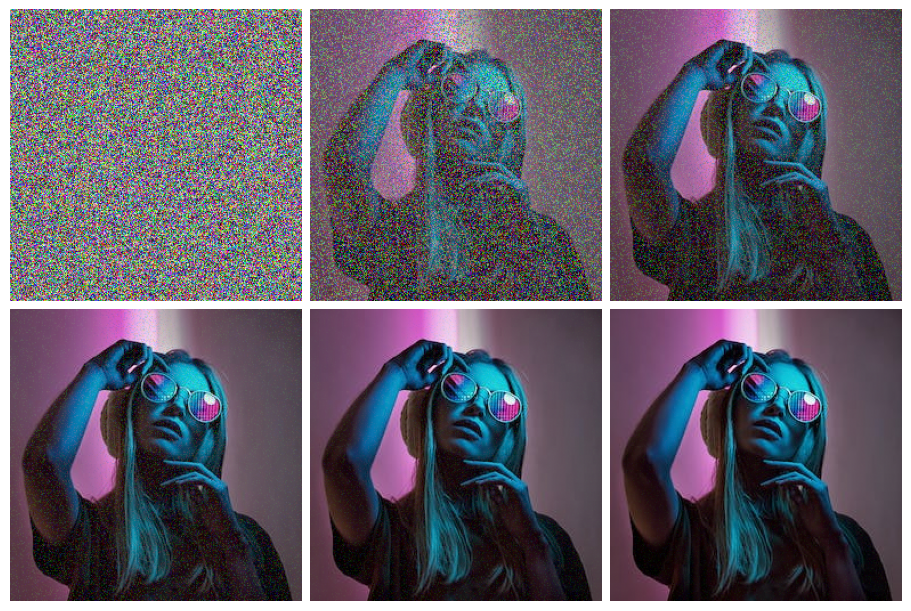

In [ ]:
model = TensorModel(torch.rand(*content_img.shape))
learn = Learner(model, getDummy_dls(150), loss_fn_mse, lr=1e-2, cbs = cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs= [ImageLogCB(30)])

## Extracting Features from a bigger pretrained model like VGG


In [ ]:
#listing all the vgg variant models
print(timm.list_models('*vgg*'))

['repvgg_a0', 'repvgg_a1', 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'repvgg_d2se', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [ ]:
#this is vgg without the header classier 
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features

In [ ]:
vgg16

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

### Normalizing 
- vgg is trained on 1M images of imageNet and expects the same mean and std stats, so lets make sure of the shapes following broadcasting rules and shapes

In [ ]:
imagenet_mean = tensor([0.485, 0.456, 0.406]) 
imagenet_std = tensor([0.229, 0.224, 0.225])

if we try to just normalise by subtracting the mean and divide by std, straight forward we would get an error     [RuntimeError: The size of tensor a (256) must match the size of tensor b (3) at non-singleton dimension 2]

In [ ]:
#(content_img - imagenet_mean)/imagenet_std

In [ ]:
content_img.shape, imagenet_mean.shape

(torch.Size([3, 256, 256]), torch.Size([3]))

In [ ]:
imagenet_mean[:,None,None].shape

torch.Size([3, 1, 1])

In [ ]:
def normalize(img):
    imagenet_mean = tensor([0.485, 0.456, 0.406])[:,None,None].to(img.device)
    imagenet_std = tensor([0.229, 0.224, 0.225])[:,None,None].to(img.device)
    return (img - imagenet_mean)/imagenet_std

In [ ]:
normalize(content_img).min(), normalize(content_img).max(), normalize(content_img).mean(dim=(1,2))

(tensor(-2.12, device='mps:0'),
 tensor(2.64, device='mps:0'),
 tensor([-0.97, -0.96, -0.42], device='mps:0'))

In [ ]:
#Using torch.vission transforms function will give us the same result
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

In [ ]:
normalize(content_img).mean(dim=(1,2))

tensor([-0.97, -0.96, -0.42], device='mps:0')

In [ ]:
def calc_features(imgs, target_layers=(18,25)):
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

In [ ]:
feat = calc_features(content_img)
[p.shape for p in feat]

[torch.Size([512, 32, 32]), torch.Size([512, 16, 16])]

In [ ]:
class contentLossToTarget():
    def __init__(self, target_im, target_layers = (18,25)):
        fc.store_attr()
        with torch.no_grad():
            self.target_features = calc_features(target_im, target_layers)
    def __call__(self, input_im):
        return sum((f1-f2).pow(2).mean() for f1,f2 in
                  zip(calc_features(input_im, self.target_layers), self.target_features))

In [ ]:
loss_func_perp = contentLossToTarget(content_img)
model = TensorModel(torch.rand(*content_img.shape))
learn = Learner(model, getDummy_dls(150), loss_func_perp, lr = 1e-2,
               cbs = cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs =[ImageLogCB(30)])

In [ ]:
loss_func_perp = contentLossToTarget(content_img, target_layers=(6,26))
model = TensorModel(torch.rand(*content_img.shape))
learn = Learner(model, getDummy_dls(150), loss_func_perp, lr = 1e-2,
               cbs = cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs =[ImageLogCB(30)])